In [2]:
import numpy as np
import csv, os
from torch.utils.data import DataLoader
from dgl.data.utils import split_dataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats

from src_chung.model import reactionMPNN, training, inference
from src_chung.dataset import GraphDataset
from src_chung.util import collate_reaction_graphs

/home/phuocchung123/anaconda3/envs/GIN_korea/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = GraphDataset('./data_chung/data_valid.npz')
valid_loader = DataLoader(
        dataset=data,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_reaction_graphs,
        drop_last=True,
    )

In [9]:
for batch in valid_loader:
    if batch[-1].size()[0] != 32:
        print(batch[-1].size())
        break

In [20]:
from collections import defaultdict

element_count = defaultdict(int)

for element in a:
    element_count[element] += 1

print(element_count)
print(len(element_count.keys()))

defaultdict(<class 'int'>, {35: 800, 41: 800, 13: 800, 4: 800, 12: 800, 26: 800, 24: 800, 27: 800, 0: 800, 2: 800, 22: 800, 7: 800, 23: 800, 32: 800, 14: 800, 19: 800, 25: 800, 36: 800, 37: 800, 17: 800, 6: 800, 1: 800, 20: 800, 40: 800, 49: 800, 3: 800, 28: 800, 33: 800, 34: 800, 10: 800, 15: 800, 48: 800, 38: 800, 5: 800, 16: 800, 30: 800, 18: 800, 39: 800, 11: 800, 44: 800, 8: 800, 31: 800, 9: 800, 45: 800, 46: 800, 47: 800, 43: 800, 21: 800, 42: 800, 29: 800})
50


In [31]:
for batch in train_loader:
    a=batch[-1]
    break

In [32]:
a.shape

torch.Size([32, 50])

In [1]:
import torch

# Generate two random numbers between 0 and 1
random_numbers = torch.rand(2)

# Since we're assuming a uniform distribution between 0 and 1 for each number,
# the probability of each number is simply 1 (the length of the interval).
probabilities = torch.ones(2)

In [14]:
import torch

# Generate two random numbers
num1 = torch.rand(1).item()
num2 = torch.rand(1).item()

# Calculate the total
total = num1 + num2

# Calculate the percentage of each number
weight1 = (num1 / total) * 100
weight2 = (num2 / total) * 100






Number 1: 0.16787117719650269, Percentage: 19.223329730622574%
Number 2: 0.7053967714309692, Percentage: 80.77667026937743%


In [ ]:
def training(
net,
train_loader,
val_loader,
model_path,
val_monitor_epoch=1,
n_forward_pass=5,
cuda=torch.device('cuda:0'),
):
train_size = train_loader.dataset.__len__()
batch_size = train_loader.batch_size
nt_xent_criterion = NTXentLoss(cuda, batch_size)

try:
    rmol_max_cnt = train_loader.dataset.dataset.rmol_max_cnt
    pmol_max_cnt = train_loader.dataset.dataset.pmol_max_cnt

except:
    rmol_max_cnt = train_loader.dataset.rmol_max_cnt
    pmol_max_cnt = train_loader.dataset.pmol_max_cnt

loss_fn = nn.CrossEntropyLoss()

n_epochs = 20
optimizer = Adam(net.parameters(), lr=5e-4, weight_decay=1e-5)

# lr_scheduler = MultiStepLR(
#     optimizer, milestones=[400, 450], gamma=0.1, verbose=False
# )

train_loss_all=[]
val_loss_all=[]
acc_all=[]
acc_all_val=[]
mcc_all=[]
mcc_all_val=[]

best_val_loss =1e10
best_loss=1e10
for epoch in range(n_epochs):
    # training
    net.train()
    start_time = time.time()
    train_loss_contra_list = []
    
    for batchdata in tqdm(train_loader, desc='Training_contra'):
        inputs_rmol = [b.to(cuda) for b in batchdata[:rmol_max_cnt]]
        inputs_pmol = [
            b.to(cuda)
            for b in batchdata[rmol_max_cnt : rmol_max_cnt + pmol_max_cnt]
        ]
        r_rep,p_rep= net(inputs_rmol, inputs_pmol)
        loss_sc=nt_xent_criterion(r_rep, p_rep)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_contra = loss.detach().item()
        train_loss_contra_list.append(train_loss_contra)

    print("--- training epoch %d, loss %.3f, time elapsed(min) %.2f---"
          % (epoch, np.mean(train_loss_contra_list), (time.time() - start_time) / 60))
    

    if np.mean(val_loss_list) < best_loss:
        best_loss = np.mean(val_loss_list)
        torch.save(net.state_dict(), model_path)



    for batchdata in tqdm(train_loader, desc='Training'):
        inputs_rmol = [b.to(cuda) for b in batchdata[:rmol_max_cnt]]
        inputs_pmol = [
            b.to(cuda)
            for b in batchdata[rmol_max_cnt : rmol_max_cnt + pmol_max_cnt]
        ]

        labels = batchdata[-1]
        targets.extend(labels.tolist())
        labels = labels.to(cuda)

        r_rep,p_rep= net(inputs_rmol, inputs_pmol)
        loss_sc=nt_xent_criterion(r_rep, p_rep)

        pred = net.predict(torch.sub(r_rep,p_rep))
        preds.extend(torch.argmax(pred, dim=1).tolist())
        loss_ce = loss_fn(pred, labels)
        loss=weight1*loss_ce+weight2*loss_sc

        ##Uncertainty 
        # loss = (1 - 0.1) * loss.mean() + 0.1 * (
        #     loss * torch.exp(-logvar) + logvar
        # ).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.detach().item()
        train_loss_list.append(train_loss)


    acc = accuracy_score(targets, preds)
    mcc = matthews_corrcoef(targets, preds)
    train_loss_all.append(np.mean(train_loss_list))
    acc_all.append(acc)
    mcc_all.append(mcc)


    if (epoch + 1) % 1 == 0:

        
        print(
            "--- training epoch %d, loss %.3f, acc %.3f, mcc %.3f, time elapsed(min) %.2f, weight1 %.3f, weight2 %.3f---"
            % (
                epoch,
                np.mean(train_loss_list),
                acc,
                mcc,
                (time.time() - start_time) / 60,
                weight1,
                weight2,
            )
        )

    # lr_scheduler.step()

    # validation with test set
    if val_loader is not None and (epoch + 1) % val_monitor_epoch == 0:

        batch_size = val_loader.batch_size

        try:
            rmol_max_cnt = val_loader.dataset.dataset.rmol_max_cnt
            pmol_max_cnt = val_loader.dataset.dataset.pmol_max_cnt

        except:
            rmol_max_cnt = val_loader.dataset.rmol_max_cnt
            pmol_max_cnt = val_loader.dataset.pmol_max_cnt

        net.eval()
        val_loss_list=[]
        val_targets=[]
        val_preds=[]

        # MC_dropout(net)


        with torch.no_grad():
            for batchdata in tqdm(val_loader, desc='Validating'):
                inputs_rmol = [b.to(cuda) for b in batchdata[:rmol_max_cnt]]
                inputs_pmol = [
                    b.to(cuda)
                    for b in batchdata[rmol_max_cnt : rmol_max_cnt + pmol_max_cnt]
                ]

                labels_val = batchdata[-1]
                val_targets.extend(labels_val.tolist())
                labels_val = labels_val.to(cuda)


                r_rep,p_rep=net(inputs_rmol, inputs_pmol)
                loss_sc=nt_xent_criterion(r_rep, p_rep)
                pred_val = net.predict(torch.sub(r_rep,p_rep))
                val_preds.extend(torch.argmax(pred_val, dim=1).tolist())    
                loss_ce=loss_fn(pred_val,labels_val)

                loss=weight1*loss_ce+weight2*loss_sc

                val_loss = loss.item()
                val_loss_list.append(val_loss)

            if np.mean(val_loss_list) < best_val_loss:
                best_val_loss = np.mean(val_loss_list)
                torch.save(net.state_dict(), model_path)

            val_acc = accuracy_score(val_targets, val_preds)
            val_mcc = matthews_corrcoef(val_targets, val_preds)


            val_loss_all.append(np.mean(val_loss_list))
            acc_all_val.append(val_acc)
            mcc_all_val.append(val_mcc)



            print(
                "--- validation at epoch %d, val_loss %.3f, val_acc %.3f, val_mcc %.3f ---"
                % (epoch, np.mean(val_loss_list),val_acc,val_mcc)
            )
            print('\n'+'*'*100)

In [1]:
import pandas as pd

data=pd.read_csv('./data_chung/schneider50k.tsv',sep='\t',index_col=0)
data.head()


,original_rxn,rxn_class,source,rxn,split
0,[CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...,6.1.5,US06887874,C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...,test
1,O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...,7.1.1,US07056926,CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...,test
2,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...,1.8.5,US08492378,COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...,test
3,Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....,2.2.3,US08592454,CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...,train
4,[CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...,1.3.7,US06716851,COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...,test


In [3]:
# from rxnmapper import RXNMapper
# from tqdm import tqdm
# rxnmapper = RXNMapper()
# lst=[]
# lst_non_idx=[]
# for idx,i in tqdm(enumerate(data['rxn'].values),desc='Running_RXNMapper'):
#     try:
#         res=rxnmapper.get_attention_guided_atom_maps([i])
#         res=res[0]['mapped_rxn']
#         lst.append(res)
#     except:
#         lst_non_idx.append(idx)

# data.drop(lst_non_idx,inplace=True)
# data['rxn_new']=lst



Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


In [4]:
print(data.loc[0,'original_rxn'])
print('\n')
print(data.loc[1,'rxn'])

[CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10][CH2:9][N:8](Cc2ccccc2)[CH2:13][CH2:12]1.C1CCCCC1>[OH-].[OH-].[Pd+2].CCO>[CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10][CH2:9][NH:8][CH2:13][CH2:12]1


CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc1.Cl[Sn]Cl.O.O.O=C([O-])O.[Na+]>>Cc1cc(N)ccc1NC(=O)c1ccccc1


In [32]:
from rxnmapper import RXNMapper
rxnmapper = RXNMapper()
# provide SMILES of reactants and products separated by >>
example_reaction = data.loc[0,'rxn']
res = rxnmapper.get_attention_guided_atom_maps([example_reaction])
res[0]['mapped_rxn']

'C1CCCCC1.CCO.c1ccc(C[N:8]2[CH2:7][CH2:6][N:5]([S:2]([CH3:1])(=[O:3])=[O:4])[CH2:10][CH2:9]2)cc1.[OH-].[OH-].[Pd+2]>>[CH3:1][S:2](=[O:3])(=[O:4])[N:5]1[CH2:6][CH2:7][NH:8][CH2:9][CH2:10]1'

In [42]:
lis=[]
lis_idx=[]
dem=0
for idx,i in enumerate(data['rxn'].values):
    p_smi=i.split('>>')[1]
    a=[]
    if len(p_smi.split('.'))>1:
        dem+=1
        if dem>1:
            lis.append(i)
            lis_idx.append(idx)
        # a.extend(p_smi.split('.'))
        # if len(a)>1:
        #     dem=0
        #     for idx,j in enumerate(a):
        #         if len(j)>1:
        #             # print(j)
        #             dem+=1
            
        #     if dem >1:
        #         lis.append(i)

In [43]:
len(lis)

2485

In [34]:
len(data.rxn.values[0].split('>>')[0].split('.'))

6

In [ ]:
idx

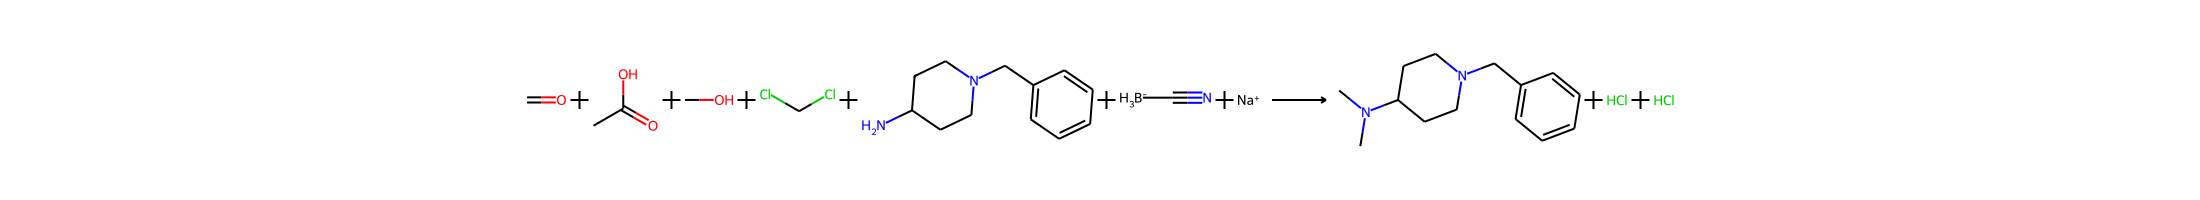

In [45]:
from rdkit.Chem import AllChem, Draw
react1=data.rxn.values[lis_idx[1]]
rxn=AllChem.ReactionFromSmarts(react1,useSmiles=True)
Draw.ReactionToImage(rxn)


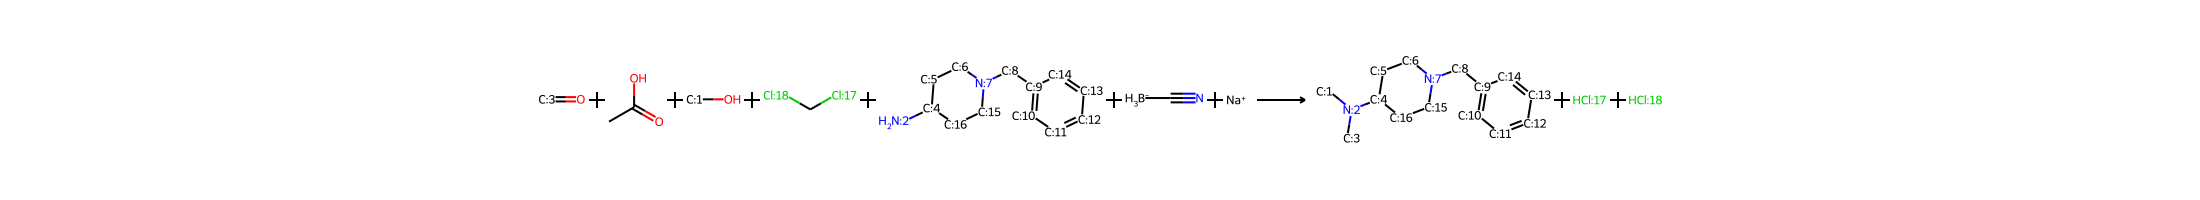

In [46]:
from rxnmapper import RXNMapper
rxnmapper = RXNMapper()
# provide SMILES of reactants and products separated by >>
example_reaction = react1
res = rxnmapper.get_attention_guided_atom_maps([example_reaction])
react1=res[0]['mapped_rxn']
rxn=AllChem.ReactionFromSmarts(react1,useSmiles=True)
Draw.ReactionToImage(rxn)

In [9]:
import torch
k=torch.rand(2)
q=torch.rand(2)
un_att=k@(q.T)
print(un_att)
print(un_att.shape)
v=torch.rand(4)

tensor(0.5022)
torch.Size([])
